<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/model_implementation/mri_classification_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploying a MRI classification app with Huggingface and Gradio

In [ ]:
!pip install --upgrade gradio

In [ ]:
!pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/model_deployment

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/ExplainableAI/model_deployment


## 1. Create a Gradio App that exposes the MRI brain tumor classification model

In [4]:
import gradio as gr

def update_gallery(images):
    """Update the gallery with the uploaded images"""
    return images

# create gradio instance demo
with gr.Blocks() as demo:
    gr.Markdown("<h1 style='text-align: center;'>MRI Brain Tumor Classification App</h1>")
    with gr.Column():
        image_input = gr.Files(label="Upload MRI Images",
                              file_count="multiple",
                              type="filepath")

        gallery = gr.Gallery(label="MRI Brain Images")

    # set up an event listener to update the gallery images when image_input changes
    image_input.change(
        fn=update_gallery,
        inputs=[image_input],
        outputs=[gallery])

# launch the app enabled to be debugged
demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://de2911cb3b502f8d15.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://de2911cb3b502f8d15.gradio.live


## 2. Gradio UI for MRI classification

### Load Vision Transformer model trained for MRI classification and image processor

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification

model = ViTForImageClassification.from_pretrained("elliemci/vit_tumor_classification_model")
image_processor = ViTImageProcessor.from_pretrained("elliemci/vit_tumor_classification_model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Image class prediction function

In [11]:
import torch
from torch.utils.data import DataLoader

def predict(images):

  batch_size = len([images]) if len(images) <= 8 else 8

  # create the data loader for all input images
  inputs_loader = DataLoader(images, batch_size=batch_size, shuffle=False)

  batch_size = len([images]) if len(images) <= 8 else 8

  # create the data loader for all input images
  inputs_loader = DataLoader(images, batch_size=batch_size, shuffle=False)

  predictions = []
  # set the model to evaluation mode
  model.eval()

  # disable gradient calculation during inference
  with torch.no_grad():
      for batch in inputs_loader:
        # preprocess the batch of images using the feature extractor
        inputs = image_processor(images=batch['image'], return_tensors="pt").to(device)
        inputs = batch['image'].to(device)
        # with dictionary unpacking operator on preprocess data, containt pizel_values and labels
        outputs = model(**inputs)
        # outputs = model(pixel_values=inputs, labels=labels)
        _, preds = torch.max(outputs.logits, 1)

        # add individual prediction iterating over the list
        predictions.extend(preds.cpu().numpy())

  return predictions # {'tumor':str(predictions), 'no-tumor':str(1-predictions)}

### Gradio UI for uploading image, making and displaying the prediction

In [ ]:
import os
import torch

from PIL import Image

def predict_image(image_path):
  """ Takes the path to an image and returns the prediction of the model """

  try:
    # open the image and convert to RGB format
    image = Image.open(image_path).convert('RGB')
    # pre-process the image with the pre-trained image processor
    input = image_processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
      outputs = model(**input)
      # extract the row outputs
      logits = outputs.logits
      predicted_class = logits.argmax(-1).item()
      prediction = "Tumor" if predicted_class == 1 else "No Tumor"

      return prediction

  except Exception as e:
    return f"Error processing image: {e}"


def update_gallery(images):
  """ Process the uploaded images and returns a list of image paths along with
      their predictions. """

  predictions = []
  image_paths = []

  if images:
    for image in images:
      # extract the file path
      image_path = image.name
      image_paths.append(image_path)
      # predict and store
      prediction = predict_image(image_path)
      predictions.append(prediction)

  # gallery expects the input in the format (image_path, prediction) for every image,
  # combine image_paths and predictions into a list of tuples (image_path, prediction)
  image_paths_with_predictions = list(zip(image_paths, predictions))

  return image_paths_with_predictions

### Gradio Tumor Classification Interface

In [17]:
# create and lauch Gradio web interface
with gr.Blocks() as demo:
    gr.Markdown("<h1 style='text-align: center;'>MRI Brain Tumor Classification App</h1>")

    with gr.Column():
      # create components
      image_input = gr.Files(label="Upload MRI Images",
                            file_count="multiple",
                            type="filepath")
      gallery = gr.Gallery(label="MRI Brain Images with Predictions")

    # set up an event listener
    image_input.change(
        fn=update_gallery,
        inputs=[image_input],
        outputs=[gallery]
    )
    # launch the app
    demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dc20b644505a65352f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://dc20b644505a65352f.gradio.live


## 3. Gradio UI for MEI segmentation

### Gradio UI for uploading image and making a prediction

### Image segmentation prediction function

In [ ]:
import torch

from transformers import MaskFormerForInstanceSegmentation, MaskFormerImageProcessor
from PIL import Image

# can upload from Huggingface Space "elliemci/maskformer_tumor_segmentation"
model = MaskFormerForInstanceSegmentation.from_pretrained("/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation/maskformer_tumor_segmentation")
image_processor = MaskFormerImageProcessor.from_pretrained("/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation/maskformer_tumor_segmentation")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [81]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from io import BytesIO

# Define a custom dataset class to handle the images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

In [82]:
def segment(image_files):
    """Takes a list of UploadedFile objects and returns a list of segmented images."""

    dataset = ImageDataset(image_files, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=len(image_files), shuffle=False)  # Batch size is the number of images

    # process a batch
    with torch.no_grad():
        for batch in dataloader:  # Only one iteration since batch_size = len(image_files)
            pixel_values = batch.to(device, dtype=torch.float32)
            outputs = model(pixel_values=pixel_values)

            # Post-processing
            original_images = outputs.get("org_images", batch)
            target_sizes = [(image.shape[-2], image.shape[-1]) for image in original_images]
            predicted_masks = image_processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

            return predicted_masks  # Return the list of segmented images

### Testing

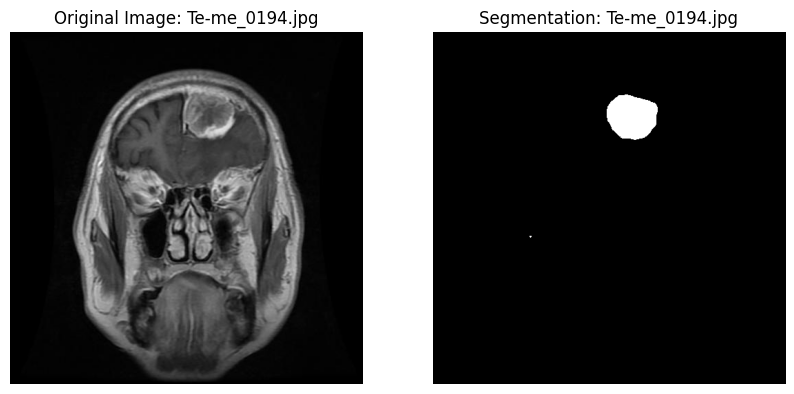

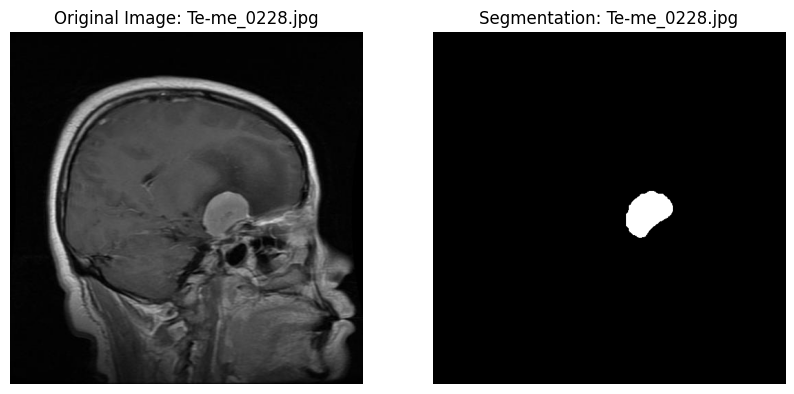

In [44]:
import matplotlib.pyplot as plt

image_paths = ["Te-me_0194.jpg", "Te-me_0228.jpg"]
segment_imgs = segment(image_paths)

for i in range(len(image_paths)):
    original_image = Image.open(image_paths[i]).convert("RGB")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image: {image_paths[i]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segment_imgs[i], cmap="gray")
    plt.title(f"Segmentation: {image_paths[i]}")
    plt.axis("off")

    plt.show()


In [ ]:
import unittest
from PIL import Image
import numpy as np

class TestSegmentFunction(unittest.TestCase):

    def test_segment(self):
        # 1. Prepare Test Data
        test_image_path = "Te-me_0194.jpg"

        # 2. Call the Function
        segmented_img = segment(test_image_path)

        # 3. Assertions
        # Check if the function returned an error message
        self.assertNotEqual(segmented_img, "Error processing image:", "The segment function returned an error.")

        # If segmentation is successful, segmented_img should be a list
        self.assertIsInstance(segmented_img, list, "The segment function should return a list.")

        # Check if the list is not empty
        self.assertTrue(len(segmented_img) > 0, "The segment function returned an empty list.")

        # Check if the first element in the list is a NumPy array
        self.assertIsInstance(segmented_img[0], np.ndarray, "The first element of the returned list should be a NumPy array.")

        # More specific assertions here to check the content of the segmented image,
        # like its shape, data type, or specific pixel values based on your expectations.
        # Example:
        # expected_shape = (512, 512, 3)  # Replace with the expected shape of your segmented image
        # self.assertEqual(segmented_img[0].shape, expected_shape, "Segmented image shape is incorrect.")

        # Example to check data type:
        # self.assertEqual(segmented_img[0].dtype, np.uint8, "Segmented image data type is incorrect.")

# Run the tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [ ]:
import unittest
from PIL import Image

class TestUpdateGallery(unittest.TestCase):

  def test_update_gallery(self):
        # 1. Prepare Test Data:
        test_image_paths = ["Te-me_0194.jpg", "Te-me_0228.jpg"]  # Replace with your test image paths
        test_images = [Image.open(path) for path in test_image_paths]  # Load test images as PIL Images

        # 2. Call the Function:
        gallery_data = update_gallery(test_images)

        # 3. Assertions:
        # a. Check the length of the gallery data:
        self.assertEqual(len(gallery_data), len(test_image_paths) * 2, "Gallery data should contain original and segmented images for each input image")

        # b. Check if segmented images are present and of the correct type:
        for i in range(0, len(gallery_data), 2): # Iterate through segmented images in the gallery data
            original_image_path, original_caption = gallery_data[i]
            segmented_image, segmented_caption = gallery_data[i + 1]

            self.assertEqual(original_caption, "Original Image")
            self.assertEqual(segmented_caption, "Segmented Image")

            # Check if segmented_image is a NumPy array
            self.assertIsInstance(segment(test_image_paths[i//2])[0], np.ndarray, "Segmented image should be a NumPy array")

            # More assertions here to check the content or properties of the segmented image:
            # - Shape of the segmented image: self.assertEqual(segmented_image.shape, expected_shape)
            # - Pixel values in the segmented image: self.assertTrue(np.all(segmented_image[some_region] == expected_value))

            # Display the segmented images (optional):
            segmented_image_pil = Image.fromarray(segmented_image)
            segmented_image_pil.show()


# Run the tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

### Gradio components to display segmentation result

## 4. Gradio Tumor Segmentation Interface

In [83]:
def update_gallery(images):
    print(f"Type in update_gallery: {type(images[0])}")
    gallery_data = []

    if images:
        segmented_images = segment(images)  # Process all images in one batch

        for i, image in enumerate(images):
            segmented_image_pil = transforms.ToPILImage()(segmented_images[i].to(device, dtype=torch.float32))
            gallery_data.extend([(image, "Original Image"), (segmented_image_pil, "Segmented Image")])

    return gallery_data

In [84]:
import gradio as gr

with gr.Blocks() as demo:
  gr.Markdown("<h1 style='text-align: center;'>MRI Brain Tumor Segmentation App</h1>")

  with gr.Column():
    with gr.Column():
      image_files = gr.Files(label="Upload MRI files",
                                     file_count="multiple",
                                     type="filepath")
      with gr.Row():
        gallery = gr.Gallery(label="Brain Imagesand Tumor Segmentation")

        image_files.change(
             fn=update_gallery,
             inputs=[image_files],
             outputs=[gallery]  # Update with placeholders for original and segmented image
        )

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c1b1989c6bcb6c434c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Type in update_gallery: <class 'gradio.utils.NamedString'>
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c1b1989c6bcb6c434c.gradio.live


### App contents

#### Text section

#### Gallery section

#### Image analysis section

### App